    ## Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras 
    to make five implementations of your network. Compare them both in computational complexity as well as 
    in accuracy and given that tradeoff decide which one you like best.

##  1. First implementation, simple MLP neural network
      
      loss = 1.7224666845321654
      Train score = 0.73   
      Test score = 0.3868

      ## result is poor. also overfit

##  2. Second implementation, Simple CNN LeNet implementation

      loss = 3.6068922271728514
      Train score = 0.9905
      Test score = 0.7116
      
      ## Overfit              

##  3. Third implementation, Hierarchical Recurrent Neural Networks

      loss = 1.1138086366653441
      Train score = 0.6695
      Test score = 0.6077

      ## not overfit. results are not good

##  4. Fourth implementation, CNN implementation

      loss = 14.5063
      Train score = 0.1000
      Test score =

      ## stuck in some local minimization

##  5. Fifth implementation, Very Complex Convoluted Neural Network

      loss = 0.8968
      Train score = 0.4341387804031372
      Test score = 0.8859 

    ## very good, even though taking long time to finish

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import cPickle

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Layer, LSTM, Input, TimeDistributed
from keras.optimizers import RMSprop
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [4]:
def tf_imgdata_generator(image, label, is_training, batch_size=128):
    '''Generate digitized (x_train,y_train) dataset'''
    
    def mapping_func(image, label):
        '''Preprocess raw image data into trainable input'''
        X = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
        Y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
        return X,Y
  

In [5]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )
        Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)



In [37]:
# load dataset
batch_size = 128
num_classes = 10
epochs = 100
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

(50000, 32, 32, 3)
(50000, 1)


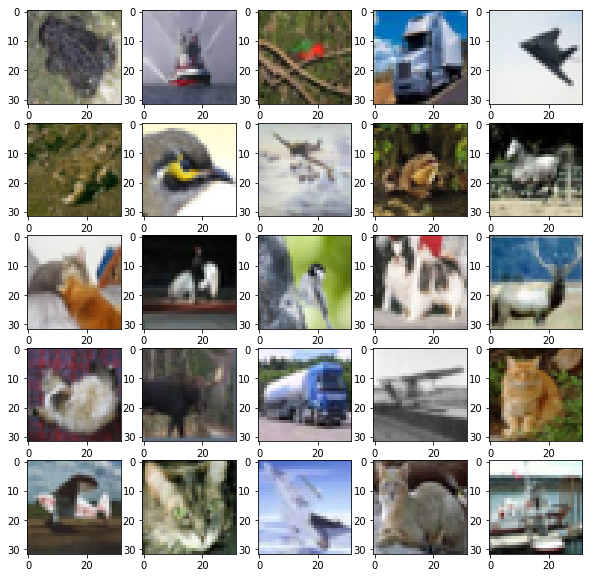

In [38]:
print(x_train.shape)
print(y_train.shape)
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for j in range(5):
    for i in range(5):
        k = np.random.choice(range(len(x_train)))
        axes[j][i].imshow(x_train[k:k+1][0], interpolation='nearest')

## First implementation, simple MLP neural network

In [39]:
# reshape the 
x_train = x_train.reshape(50000, 3072)
x_test = x_test.reshape(10000, 3072)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# sequential model
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                196672    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 201,482
Trainable params: 201,482
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(x_train, y_train,
                   batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test score {}'.format(score[1]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 88us/step - loss: 2.1110 - acc: 0.2205 - val_loss: 1.8903 - val_acc: 0.3226
Epoch 2/10
50000/50000 [==============================] - 3s 70us/step - loss: 1.9211 - acc: 0.2996 - val_loss: 1.8386 - val_acc: 0.3388
Epoch 3/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.8740 - acc: 0.3179 - val_loss: 1.8175 - val_acc: 0.3412
Epoch 4/10
50000/50000 [==============================] - 4s 77us/step - loss: 1.8423 - acc: 0.3330 - val_loss: 1.7560 - val_acc: 0.3705
Epoch 5/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.8197 - acc: 0.3401 - val_loss: 1.7499 - val_acc: 0.3758
Epoch 6/10
50000/50000 [==============================] - 4s 82us/step - loss: 1.8004 - acc: 0.3484 - val_loss: 1.7560 - val_acc: 0.3738
Epoch 7/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.7842 - acc: 0.3564 - val_loss: 1.7554 - val_acc

In [32]:
print(x_test.shape)

(10000, 3072)


## Second implementation, Simple CNN LeNet implementation

In [63]:
# load dataset
batch_size = 128
num_classes = 10
epochs = 50
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

In [64]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

In [65]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=x_train.shape[1:]))            
#                 input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [66]:
history = model.fit(x_train, y_train,
                   batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))
model.summary()
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test score {}'.format(score[1]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 109s 2ms/step - loss: 1.5094 - acc: 0.4655 - val_loss: 1.1613 - val_acc: 0.5984
Epoch 2/50
50000/50000 [==============================] - 102s 2ms/step - loss: 1.0381 - acc: 0.6385 - val_loss: 0.9849 - val_acc: 0.6524
Epoch 3/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.8104 - acc: 0.7189 - val_loss: 0.9649 - val_acc: 0.6840
Epoch 4/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.6322 - acc: 0.7820 - val_loss: 0.9266 - val_acc: 0.7031
Epoch 5/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.4717 - acc: 0.8364 - val_loss: 0.9152 - val_acc: 0.7216
Epoch 6/50
50000/50000 [==============================] - 104s 2ms/step - loss: 0.3326 - acc: 0.8847 - val_loss: 1.1206 - val_acc: 0.6922
Epoch 7/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.2258 - acc: 0.9228 - val_loss: 1.4785 - 

Test loss: 3.6068922271728514
Test score 0.7116


## Third implementation, Hierarchical Recurrent Neural Networks

In [51]:
# load dataset
batch_size = 128
num_classes = 10
epochs = 100
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

row_hidden = 32
col_hidden = 32

row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# reshape the 
#x_train = x_train.reshape(50000, 3072)
#x_test = x_test.reshape(10000, 3072)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation.
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 180s 4ms/step - loss: 2.0475 - acc: 0.2467 - val_loss: 1.9511 - val_acc: 0.2984
Epoch 2/100
50000/50000 [==============================] - 169s 3ms/step - loss: 1.9176 - acc: 0.3100 - val_loss: 1.8516 - val_acc: 0.3291
Epoch 3/100
50000/50000 [==============================] - 171s 3ms/step - loss: 1.8336 - acc: 0.3362 - val_loss: 1.8563 - val_acc: 0.3306
Epoch 4/100
50000/50000 [==============================] - 170s 3ms/step - loss: 1.7533 - acc: 0.3645 - val_loss: 1.7105 - val_acc: 0.3759
Epoch 5/100
50000/50000 [==============================] - 164s 3ms/step - loss: 1.7025 - acc: 0.3794 - val_loss: 1.6571 - val_acc: 0.3993
Epoch 6/100
50000/50000 [==============================] - 168s 3ms/step - loss: 1.6626 - acc: 0.3965 - val_loss: 1.6210 - val_acc: 0.4103
Epoch 7/100
50000/50000 [==============================] - 170s 3ms/step - loss: 1.6278 - acc: 0.4070 - val_loss: 1.

In [50]:
print(x_test.shape)

(10000, 32, 32, 3)


## Fourth implementation, CNN

In [ ]:
# load dataset
batch_size = 128
num_classes = 10
epochs = 50
(x_train,y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=x_train.shape[1:]))            
#                 input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                   batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))
model.summary()
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test score {}'.format(score[1]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5026 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/100
50000/50000 [==============================] - 99s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - 

50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 59/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 60/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 61/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 62/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 63/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 64/100
50000/50000 [==============================] - 100s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 65/100
50000/

## Fifth implementation, Very Complex Convoluted Neural Network

In [ ]:
x = Reshape((-1, 128))(x)
capsule = Capsule(10, 16, 3, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()


In [ ]:
data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        workers=4)

In [34]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: {} loss: {}'.format(scores[1]*100,scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Epoch 34/125
781/781 [==============================] - 936s 1s/step - loss: 0.6225 - acc: 0.8355 - val_loss: 0.6773 - val_acc: 0.8254
Epoch 35/125
781/781 [==============================] - 933s 1s/step - loss: 0.6220 - acc: 0.8352 - val_loss: 0.6331 - val_acc: 0.8378
Epoch 36/125
781/781 [==============================] - 941s 1s/step - loss: 0.6181 - acc: 0.8382 - val_loss: 0.6392 - val_acc: 0.8325
Epoch 37/125
781/781 [==============================] - 939s 1s/step - loss: 0.6191 - acc: 0.8388 - val_loss: 0.6057 - val_acc: 0.8508
Epoch 38/125
781/781 [==============================] - 940s 1s/step - loss: 0.6129 - acc: 0.8386 - val_loss: 0.5851 - val_acc: 0.8542
Epoch 39/125
781/781 [==============================] - 933s 1s/step - loss: 0.6141 - acc: 0.8387 - val_loss: 0.5689 - val_acc: 0.8607
Epoch 40/125
781/781 [==============================] - 932s 1s/step - loss: 0.6133 - acc: 0.8414 - val_loss: 0.6077 - val_acc: 0.8470
Epoch 41/125
781/781 [==============================] -